# Competição DSA de Machine Learning - Edição Janeiro/2019
## CRISP-DM: Evaluation
**Autor:** Wanderson Marques - wdsmarques@gmail.com

Nesse notebook é realizada a **avaliação** do modelo preditivo, onde os dados de validação são utilizados para verificar a capacidade preditiva. Essa é a quinta fase da metodologia CRISP-DM, o evaluation. 

<img src="imgs/evaluation.jpg" />

### Carregar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

In [2]:
# Exibir gráficos dentro do Jupyter Notebook
% matplotlib inline

# Definir tamanho padrão para os gráficos
rcParams['figure.figsize'] = 8, 4

### Carregar dataset de validação

In [3]:
dataset = pd.read_csv('datasets/valid.csv')
dataset.head()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
0,1,100,72,12,70,25.3,0.658,28,0
1,5,168,64,0,0,32.9,0.135,41,1
2,8,120,78,0,0,25.0,0.409,64,0
3,14,175,62,30,0,33.6,0.212,38,1
4,1,138,82,0,0,40.1,0.236,28,0


### Carregar modelo preditivo

Nesse momento o modelo preditivo já foi treinado, com os dados de treino.

In [4]:
model = joblib.load('models/model.pkl')

### Carregar scaler

In [5]:
scaler = joblib.load('models/scaler.pkl')

### Preparar os dados de validação

In [6]:
# Converter atributos zerados (fora de domínio) para nulo
naoZero = ['glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi']
for coluna in naoZero:
    dataset.loc[dataset[coluna] == 0, coluna] = np.NaN

In [7]:
dataset.loc[(dataset['glicose'].isnull()) & (dataset['classe'] == 0), 'glicose'] = 106.0
dataset.loc[(dataset['glicose'].isnull()) & (dataset['classe'] == 1), 'glicose'] = 141.5

In [8]:
dataset.loc[(dataset['bmi'].isnull()) & (dataset['classe'] == 0), 'bmi'] = 29.8
dataset.loc[(dataset['bmi'].isnull()) & (dataset['classe'] == 1), 'bmi'] = 34.3

In [9]:
dataset.loc[(dataset['pressao_sanguinea'].isnull()) & (dataset['classe'] == 0), 'pressao_sanguinea'] = 70.0
dataset.loc[(dataset['pressao_sanguinea'].isnull()) & (dataset['classe'] == 1), 'pressao_sanguinea'] = 74.0

In [10]:
# Função para estimar um valor y dado um valor x com Regressão Linear
def LinearReg(name, df, x_label, y_label):
    filterdf = (df[y_label].isnull()) & (df[x_label].notnull())
    model = joblib.load('models/'+name+'.pkl')
    
    if len(df.loc[filterdf, [x_label]]) > 0:
        df.loc[filterdf, [y_label]] = np.around(model.predict(df.loc[filterdf, [x_label]]))
    
    return df

# Imputar grossura_pele utilizando bmi
dataset = LinearReg('reg-grossura_pele', dataset, 'bmi', 'grossura_pele')

# Imputar insulina utilizando glicose
dataset = LinearReg('reg-insulina', dataset, 'glicose', 'insulina')

In [11]:
dataset.isnull().sum()

num_gestacoes        0
glicose              0
pressao_sanguinea    0
grossura_pele        0
insulina             0
bmi                  0
indice_historico     0
idade                0
classe               0
dtype: int64

### Separar atributos e classe 

In [12]:
X = dataset.drop(['classe'], axis=1)
y = dataset['classe']

### Padronizar atributos

In [13]:
X = scaler.transform(X)

### Realizar predição para conjunto de validação

In [14]:
y_pred = model.predict(X)

### Gerar matriz de confusão

Text(0.5,15,'Predicted label')

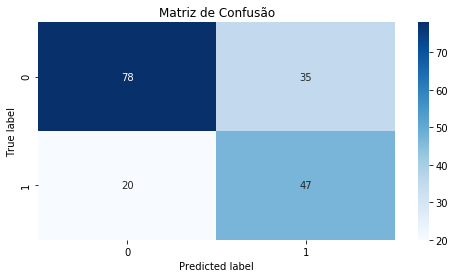

In [15]:
cm = confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5,15,'Predicted label')

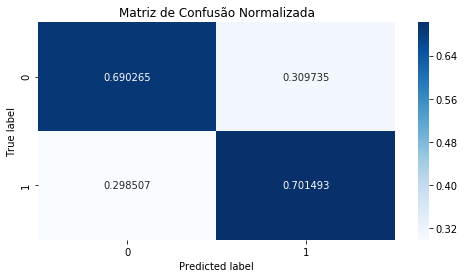

In [16]:
sns.heatmap(cm/cm.sum(axis=1)[:, np.newaxis], annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusão Normalizada')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Calcular métricas de classificação

In [17]:
accuracy_score(y, y_pred)

0.6944444444444444

In [18]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.69      0.74       113
          1       0.57      0.70      0.63        67

avg / total       0.71      0.69      0.70       180



### Gerar curva ROC

In [19]:
y_proba = model.predict_proba(X)

In [20]:
fp, tp, thresholds = roc_curve(y, y_proba[:,1])

Text(0.5,1,'Curva ROC')

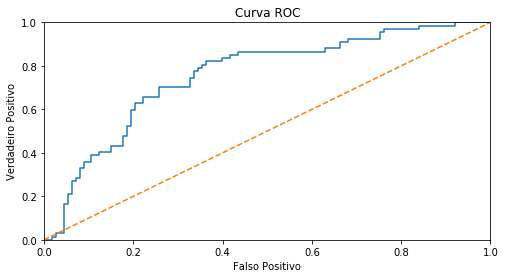

In [21]:
plt.plot(fp, tp)

plt.plot([0, 1], [0, 1], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')

In [22]:
# Área sob a curva ROC
auc(fp, tp)

0.7569673755118214